In [1]:
import re
import contractions # expand contractions, possibly switch to pyconstractions
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

Install additional libraires from README file

### Dataset Analysis

In [3]:
# Set folder path to the dataset
path = '../data/'

# Read data file into a DataFrame
raw_df = pd.read_csv(path + 'imdb_dataset.csv')
raw_df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [4]:
# Print the number of rows and columns in the DataFrame
print('Shape:', raw_df.shape)

# Calculate the amount of missing values in the DataFrame
print('Missing values:', raw_df.isnull().sum().sum())

Shape: (46500, 2)
Missing values: 0


In [5]:
# Split DataFrame into reviews and sentiment
x_raw_df = raw_df.iloc[:,0]
y_raw_df = raw_df.iloc[:,1]

# Print the number of rows and columns in reviews DataFrame
print('Shape of x_raw_df:', x_raw_df.shape)

# Print the unique classes from sentiment, and check if classes are balanced 
print('Unique classes in y_raw_df:', y_raw_df.unique())
print('Representation of each class:', y_raw_df.value_counts())

Shape of x_raw_df: (46500,)
Unique classes in y_raw_df: ['positive' 'negative']
Representation of each class: sentiment
positive    25000
negative    21500
Name: count, dtype: int64


In [6]:
# Calculate the number of words in each row
x_raw_df['word_count'] = raw_df['review'].apply(lambda x: len(str(x).split()))
x_raw_df['word_count'].head()

# Calculate the total sum of words
total_word_count = x_raw_df['word_count'].sum()

# Display the count
print('Total number of words in dataset:', total_word_count)

Total number of words in dataset: 10749531


In [7]:
# Replace sentiment labels with numbers, to ensure easier work
y_raw_df = y_raw_df.replace({'negative':0, 'positive':1})

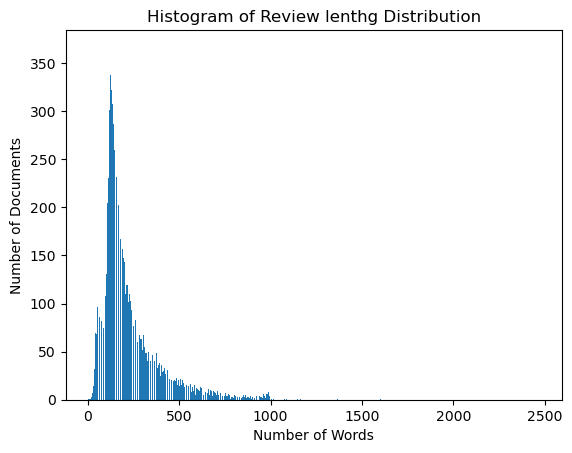

In [8]:
# Histogram representing review length distribution
plt.bar(x_raw_df['word_count'].value_counts().index, x_raw_df['word_count'].value_counts().values)
plt.xlabel('Number of Words')
plt.ylabel('Number of Documents')
plt.title('Histogram of Review lenthg Distribution')
plt.show()

### Define functions needed for cleaning

In [9]:
def initialize_objects(language = 'english', spell_distance = 1):
    
    # Define language for a dictionary to be used for removal of stop words
    stop = stopwords.words(language)

    # Initialize SpellChecker with a maximum Levenshtein distance of 1
    spell = SpellChecker(distance = spell_distance) # For longer words 1 is recommended, try 2 for shorter

    # Initialize the Porter Stemmer for stemming
    stemmer = PorterStemmer()

    # Initialize the WordNet lematizer
    lemmatizer = WordNetLemmatizer()

    return stop, spell, stemmer, lemmatizer

In [10]:
def count_unique_words(df, column_name):

    # Flatten the list of words in given column
    all_words = [word for x in df[column_name] for word in x]    

    # Calculate the number of unique words
    unique_words = len(set(all_words))

    return unique_words

In [11]:
def lowercase_text(df, column_name):

    # Use the apply method to convert each text entry to lowercase
    df[column_name] = df[column_name].apply(lambda x: x.lower())

    return df

In [12]:
def count_expression(df, column_name, expression):

    # Create a temporary column to store the counts
    df['temp'] = df[column_name].apply(lambda x: len(re.findall(expression, x)))
    
    # Calculate the total sum of occurrences across all rows
    total_occurrences = df['temp'].sum()
    
    # Drop the temporary column not to waste space
    df.drop(columns = ['temp'], inplace=True)

    return total_occurrences

In [13]:
def split_contractions(df, column_name):    

    # Define a regular expression to identify contractions, considering cases where there is a letter before and after the apostrophe
    # For example, "don't" is considered a contraction, but cases like "t ' " are ignored as potential typos
    apostrophe_expression = r'[a-zA-Z]\'[a-zA-Z]'

    # Count the number of contractions before fixing
    count_before = count_expression(df, column_name, apostrophe_expression)

    # Apply fix function to expand contractions
    df[column_name] = df[column_name].apply(contractions.fix)

    # Count the number of contractions after fixing
    count_after = count_expression(df, column_name, apostrophe_expression)

    return df, count_before, count_after

In [14]:
def replace_smiley(df, column_name):  

    # Define regular expressions to identify symbols for smileys
    sad_expression, happy_expression = r':\(', r':\)'

    # Count the number of occurances of happy and sad smiley before replacing
    count_sad = count_expression(df, column_name, sad_expression)
    count_happy = count_expression(df, column_name, happy_expression)

    # Replace :) and :( with happy and sad
    df[column_name] = df[column_name].apply(lambda x: re.sub(sad_expression, ' sad ', x))    
    df[column_name] = df[column_name].apply(lambda x: re.sub(happy_expression, ' happy ', x))

    return df, count_sad, count_happy

In [15]:
def clean_text(df, column_name):  

    # Define regular expressions for cleaning
    url_expression, tags_expression, others_expression, apostrophe_expression, underscore_expression = r'https?://\S+', r'<.*?>', r'[^\w\s\d]', r'\'', r'_+'
        
    # Count occurances before cleaning and apply cleaning for URLs 
    count_url = count_expression(df, column_name, url_expression)
    df[column_name] = df[column_name].apply(lambda x: re.sub(url_expression, ' ', x))

    # Count occurances before cleaning and apply cleaning for tags 
    count_tags = count_expression(df, column_name, tags_expression)
    df[column_name] = df[column_name].apply(lambda x: re.sub(tags_expression, ' ', x))

    # Count occurances before cleaning and apply cleaning for non-word and non-whitespace characters
    count_other = count_expression(df, column_name, others_expression) + count_expression(df, column_name, apostrophe_expression) + count_expression(df, column_name, underscore_expression)
    df[column_name] = df[column_name].apply(lambda x: re.sub(apostrophe_expression, '', x)) # don't -> dont 
    df[column_name] = df[column_name].apply(lambda x: re.sub(underscore_expression, ' ', x))
    df[column_name] = df[column_name].apply(lambda x: re.sub(others_expression, ' ', x))
    
    return df, count_url, count_tags, count_other

In [16]:
def remove_digits(df, column_name):

    # Define a regular expression to identify digits for cleaning
    digits_expression =  r'[\d]'

    # Count the number of occurances of digits before removing them
    count_digits = count_expression(df, column_name, digits_expression)

    # Remove digits
    df[column_name] = df[column_name].apply(lambda x:re.sub(digits_expression, ' ', x))

    return df, count_digits

In [17]:
def replace_digits(df, column_name):
    
    # Define a regular expression to identify digits to be replaced, add 'Rating out of' 
    digit_expression = r'(\d)\s*/\s*(5|10)|(10\s*/\s*10)'

    # Count the number of occurances of expressions before removing them
    count_digit = count_expression(df, column_name, digit_expression)
    
    # Function that replaces matched digits with corresponding words
    def replace_digit_func(match):
        
        # Extract digits from the matched groups in () from expressions, and handle None cases
        digit = int(match.group(1)) if match.group(1) is not None else None
        digit2 = int(match.group(2)) if match.group(2) is not None else None

        # Replace digits bases on different conditions handling /5 and /10 cases
        if (digit2 == 10 and 1 <= digit <= 3) or (digit2 == 5 and 1 <= digit <= 2):
            return ' Negative '
        elif (digit2 == 10 and 4 <= digit <= 7) or (digit2 == 5 and digit == 3):
            return ' Neutral '
        elif match.group(3):
            return ' Positive '
        else:
            return ' Positive '
        
    # Replace digits    
    df[column_name] = df[column_name].apply(lambda x: re.sub(digit_expression, replace_digit_func, x))

    return df, count_digit

In [18]:
def correct_spelling(df, column_name, spell_checker):

    # Create a temporary column to store the original values for later comparison
    df['temp'] = df[column_name]

    # Apply spell checker to each word in the specified column
    df[column_name] = df[column_name].apply(lambda x: ' '.join([spell_checker.correction(word) or word for word in x.split()]))
    
    # For each row, compare each word and calculate the sum of differences
    df['differences'] = df.apply(lambda x: sum(w1.lower() != w2.lower() for w1, w2 in zip(x[column_name].split(), x['temp'].split())), axis=1)

    # Show fixed word
    #df['differences'], df['s'] = zip(*df.apply(lambda x: (sum(w1.lower() != w2.lower() for w1, w2 in zip(x[column_name].split(), x['temp'].split())), [w2 for w1, w2 in zip(x[column_name].split(), x['temp'].split()) if w1.lower() != w2.lower()]), axis=1))

    # Calculate the total sum of spelling differences across all rows
    total_differences = df['differences'].sum()

    # Drop the temporary column not to waste space
    df.drop(columns=['temp', 'differences'], inplace=True)
    
    return df, total_differences

In [19]:
def tokenize_and_remove_stop(df, column_name, stop, remove_stop):

    # Remove stop words if needed, otherwise only tokenize (break down text to individual words)
    if remove_stop:
        df[column_name] = df[column_name].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop])
    else:
        df[column_name] = df[column_name].apply(word_tokenize)

    return df

In [20]:
#def random_oversampling(raw_df):
#    
#    oversample = RandomOverSampler(sampling_strategy = 'minority')
#
#    x_raw_df = raw_df.iloc[:,0]
#    y_raw_df = raw_df.iloc[:,1]
#
#    X_res, y_res = oversample.fit_resample(x_raw_df, y_raw_df)
#
#    return X_res, y_res

In [21]:
def stemming(df, column_name, stemmer):
   
    # Apply stemming to each word in the specified column
    df[column_name] = df[column_name].apply(lambda x: [stemmer.stem(word) for word in x])

    return df

In [22]:
def get_wordnet_pos(treebank_tag):

    # Map corresponding treebank tags to wordnet speech names, so that it can be read by the Lemmatizer 
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    # Return noun as a default pos for lemmatization
    else:
        return wordnet.NOUN

In [23]:
def lemmatization(df, column_name, lemmatizer):

    # Apply lemmatization with POS tagging to each word in previously tokenized columns, as it works better with pos
    df[column_name] = df[column_name].apply(lambda x: [lemmatizer.lemmatize(word, pos = get_wordnet_pos(pos_tag)) for word, pos_tag in pos_tag(x)])

    # This line includes pos information in the output as well
    #df[column_name] = df[column_name].apply(lambda x: [(lemmatizer.lemmatize(word, pos = get_wordnet_pos(pos_tag)), get_wordnet_pos(pos_tag), word) for word, pos_tag in pos_tag(x)])

    return df

In [24]:
def preprocess_data(df, column_name, split_contractions_bool, correct_spelling_bool, stemming_bool):
    
    stop, spell, stemmer, lemmatizer = initialize_objects()

    # Make a copy of the DataFrame to avoid modifying the original
    modified_df = df.copy()

    # Function that converts letters to lovercases
    modified_df = lowercase_text(modified_df, column_name)

    if split_contractions_bool:
        # Function that expands contractions
        modified_df, a, b = split_contractions(modified_df, column_name)
        print('\tNumber of \' before fixing contractions: ', a,', number of \' after fixing contractions: ', b, sep = '')

    # Function that removes non-word and non-whitespace characters
    modified_df, c, d, e = clean_text(modified_df, column_name)
    print('\tNumber of urls removed: ', c,', html tags removed: ', d, ', other characters removed: ', e, sep = '')

    # Function that removes digits
    modified_df, f = remove_digits(modified_df, column_name)
    print('\tNumber of digits removed:', f)

    if correct_spelling_bool:
        # Function that checks spelling for every word and corrects misspelled ones
        modified_df, g = correct_spelling(modified_df, column_name, spell)
        print('\tNumber of spelling mistakes that got corrected:', g)

    # Apply function that breaks down text to individual words
    modified_df = tokenize_and_remove_stop(modified_df, column_name, stop, True)   

    # Apply stemming or lemmatization based on the specified option
    if stemming_bool == 'stem':
        # # Apply function that shortens words by removing prefixes and sufixes
        modified_df = stemming(modified_df, column_name, stemmer)
    else:
        # Apply function that reduces words to their root form based on their gramatical function in sentence
        modified_df = lemmatization(modified_df, column_name, lemmatizer)

    return modified_df

### Apply cleaning functions and export datasets

In [25]:
# Create a new DataFrame to have original one as a backup
modified_df = pd.DataFrame()
modified_df['review'] = raw_df['review']
modified_df['cleaned_review'] = raw_df['review']

# Drop review column, and add sentiment column from the original dataset
modified_df.drop(columns = 'review', inplace = True)
modified_df['sentiment'] = y_raw_df

In [26]:
# Set folder path to the dataset and an incremental variable
path, i = '../data/', 0

# Create a list of all possible combinations
combinations = [(split_contractions_bool, correct_spelling_bool, stemming_bool) 
                for split_contractions_bool in [True, False]
                for correct_spelling_bool in [True, False]
                for stemming_bool in ['stem', 'lem']]

# Iterate through combinations
for split_contractions_bool, correct_spelling_bool, stemming_bool in combinations:
    
    i+=1
     
    # Print information about the current iteration 
    print(f"\n{i}. Split Contractions = {split_contractions_bool}, Correct Spelling = {correct_spelling_bool}, Stemming/Lemmatization = {stemming_bool}")
  
    # Pricess the data
    processed_df = preprocess_data(modified_df, 'cleaned_review', split_contractions_bool, correct_spelling_bool, stemming_bool)
    
    # Save the processed DataFrame to CSV
    file_name = f'split_{str(split_contractions_bool)[0]}_spel_{str(correct_spelling_bool)[0]}_{stemming_bool}.csv'
    processed_df.to_csv(path + file_name, index = False)


1. Split Contractions = True, Correct Spelling = True, Stemming/Lemmatization = stem
	Number of ' before fixing contractions: 206833, number of ' after fixing contractions: 56341
	Number of urls removed: 121, html tags removed: 187464, other characters removed: 1822452
	Number of digits removed: 150344
	Number of spelling mistakes that got corrected: 158244

2. Split Contractions = True, Correct Spelling = True, Stemming/Lemmatization = lem
	Number of ' before fixing contractions: 206833, number of ' after fixing contractions: 56341
	Number of urls removed: 121, html tags removed: 187464, other characters removed: 1822452
	Number of digits removed: 150344
	Number of spelling mistakes that got corrected: 158244

3. Split Contractions = True, Correct Spelling = False, Stemming/Lemmatization = stem
	Number of ' before fixing contractions: 206833, number of ' after fixing contractions: 56341
	Number of urls removed: 121, html tags removed: 187464, other characters removed: 1822452
	Number